In [457]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

df = pd.read_csv('../data/processed/Dronninglund_treated_data_and_flow_rates.csv', index_col=0, parse_dates=True)
water_sensors = ['T_{:04.1f}'.format(height) for height in np.linspace(16, 0.5, 32)]
df_water_sensors = df[water_sensors[::-1]]
df_water_sensors.columns = [float(c[2:]) for c in water_sensors[::-1]]
water_sensors = df_water_sensors['2017':'2020']
water_sensors = water_sensors.resample('h').mean()
water_sensors = water_sensors.iloc[19500:26000]
p1d = pd.read_csv('../predictions/p1d.csv', index_col=0)
p2d = pd.read_csv('../predictions/p2d.csv', index_col=0)
p1w = pd.read_csv('../predictions/p1w.csv', index_col=0)
p2w = pd.read_csv('../predictions/p2w.csv', index_col=0)
p1m = pd.read_csv('../predictions/p1m.csv', index_col=0)
sim = pd.read_csv('../predictions/sim.csv', index_col=0)


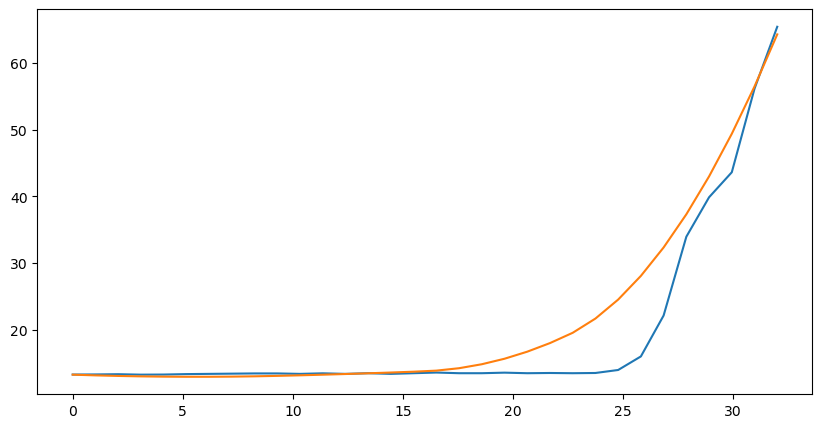

In [458]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x1 = np.linspace(0, 32, 32)
x2 = np.linspace(0, 32, 6)
# x2 = np.array([1.5,4.5,7.5,10.5,13.5,16.5])
idx = 100
f = interp1d(x2, p1m.iloc[idx], kind='quadratic')
y = f(x1)
ax.plot(x1,water_sensors.iloc[idx])
ax.plot(x1,y)

In [459]:
x2

array([ 0. ,  6.4, 12.8, 19.2, 25.6, 32. ])

# Evaluation

In [460]:
# Volumes
a = 90.4 # side length of top surface
layer_height = 0.5 # water layer height

volume_per_layer = []
top_area_per_layer = []
for _ in range(1, 33):
    b = a - 2 # the slope is 1:2 thus giving 1 m length at each side
    layer_volume = layer_height / 3 *(a**2 + a*b + b**2)
    volume_per_layer.append(layer_volume)
    top_area_per_layer.append(a**2)
    a = b

top_area_per_layer.append(b**2)

# volume_per_layer = pd.Series(volume_per_layer)
volume_per_layer = volume_per_layer[::-1]
# top_area_per_layer = pd.Series(top_area_per_layer)
top_area_per_layer = top_area_per_layer[::-1]

x = np.linspace(0, 16, 33)
d = interp1d(x, np.cumsum([0] + volume_per_layer), kind='quadratic')
x = np.linspace(0, 16, 33)
a = interp1d(x, top_area_per_layer, kind='quadratic')

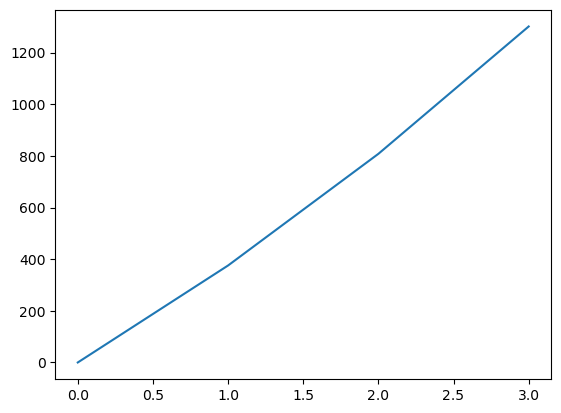

In [461]:
plt.plot(np.cumsum([0]+volume_per_layer)[:4]) 
# plt.plot(top_area_per_layer)  ¨


In [462]:
def getVolandCentroid(z, dz):
    a_bot = a(z)
    a_top = a(z+dz)
    volume = d(z+dz) - d(z)
    a_, b_ = np.sqrt(a_top), np.sqrt(a_bot)
    centroid = dz - dz * (a_top+2*a_*b_+3*a_bot) / (2*(2*a_top+2*a_*b_+2*a_bot))

    return volume, centroid + z


z = np.arange(0, 16, 0.5 )
dz = 0.5


In [463]:
water_sensors.min()

0.5     11.466667
1.0     11.500000
1.5     11.733333
2.0     11.800000
2.5     11.916667
3.0     12.250000
3.5     12.300000
4.0     12.366667
4.5     12.500000
5.0     12.700000
5.5     12.683333
6.0     12.733333
6.5     12.900000
7.0     13.100000
7.5     13.000000
8.0     13.200000
8.5     13.300000
9.0     13.300000
9.5     13.300000
10.0    13.300000
10.5    13.300000
11.0    13.300000
11.5    13.300000
12.0    13.300000
12.5    13.400000
13.0    13.400000
13.5    14.066667
14.0    20.250000
14.5    32.766667
15.0    38.900000
15.5    38.900000
16.0    38.733333
dtype: float64

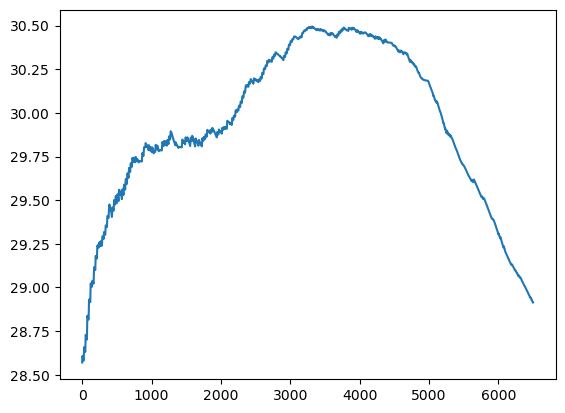

In [467]:
# Compute that god damm MIX number!
TMIN, TMAX = 10, 90

def density_water(T):
    '''Density (rho) of water in kg/m^3 based on fluid temperature (T) nearest the flow meter in degrees Celsius'''
    rho = (999.85+5.332*(10**-2)*T-7.564*(10**-3)*(T**2)+4.323*(10**-5)*(T**3)-1.673*(10**-7)*(T**4)+2.447*(10**-10)*(T**5))
    return(rho)

def specific_heat_water(T):
    '''Specific heat (cp) of water in J/(kg K) based on mean fluid temperature (T) in degrees Celsius'''
    cp = (4.2184-2.8218*(10**-3)*T+7.3478*(10**-5)*(T**2)-9.4712*(10**-7)*(T**3)+7.2869*(10**-9)*(T**4)-2.8098*(10**-11)*(T**5)
          +4.4008*(10**-14)*(T**6))*1000
    return(cp)

def mass(T, V):
    ''' Returns the mass profile of the storage given temperatures T and volumes V'''
    return density_water(T)*V

def energy(T, V):
    ''' Returns the energy profile of the storage given temperatures T and volumes V'''
    return mass(T, V)*specific_heat_water(T)*(T-TMIN)

def energy_content(y, v):
    ''' Returns the energy content of the storage given temperatures y and volumes v'''
    y = y.values
    if y.ndim == 1:
        y = y.reshape(1, -1)
    E = energy(y, v)
    return E.sum(axis =1)

def weighted_avg_temp(y, v):
    ''' Returns the weighted average temperature of the storage given temperatures y and volumes v'''
    y_ = y.values
    if y_.ndim == 1:
        y_ = y_.reshape(1, -1)
    m = mass(y_, v)
    t_avg =(m*y_).sum(axis = 1)/m.sum(axis = 1)
    # t_avg = (m*y_).mean(axis = 1)
    return pd.DataFrame(np.ones_like(y) * t_avg.reshape(-1,1), columns=y.columns)

def stratified(T,v):
    ''' Returns the stratified energy content of the storage given energy E'''
    # rho = density_water(TMAX)
    # cp = specific_heat_water(TMAX)

    E = energy_content(T, v)
    yt = np.ones_like(T) * TMAX
    yt = pd.DataFrame(yt, columns=T.columns)

    et = energy(yt, v).cumsum(axis=1) 
    z = np.abs(et.values - E.reshape(-1,1)).argmin(axis=1) / 32 * 16
    dz = 16-z
    v,c = getVolandCentroid(z, dz)
    print(E.reshape(-1,1).shape)
    return     energy_moment(TMAX, v, c)


    
def energy_moment(y, v, c):
    ''' Returns the energy moment of the storage given temperatures y, volumes v and centroids c'''
    if type(y) != int:
        y = y.values
        if y.ndim == 1:
            y = y.reshape(1, -1)
        
        E = energy(y, v)
        return (E * c).sum(axis =1)
    else:
        E = energy(y, v)
        return (E * c)
    



x2 = np.linspace(0, 32, 6)
y = water_sensors.iloc[1:2]
z = np.arange(0, 16, 0.5)
dz = 0.5
v, c = getVolandCentroid(z, dz)
N = 32
QMAX = np.sum(v) * density_water(TMAX) * specific_heat_water(TMAX) * (TMAX - TMIN)





t_avg = weighted_avg_temp(water_sensors.iloc[:], v)



# plt.plot(energy_content(t_avg, v) - energy_content(water_sensors.iloc[:], v))
energy_moment(t_avg, v, c).shape
# plt.plot(stratified(water_sensors.iloc[:], v))
plt.plot(np.log(energy_content(water_sensors.iloc[:], v)))